In [2]:
from roboflow import Roboflow
import supervision as sv
import cv2
import getpass

loading Roboflow workspace...
loading Roboflow project...


SupervisionWarnings: from_roboflow is deprecated: `Detections.from_roboflow` is deprecated and will be removed in `supervision-0.22.0`. Use `Detections.from_inference` instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


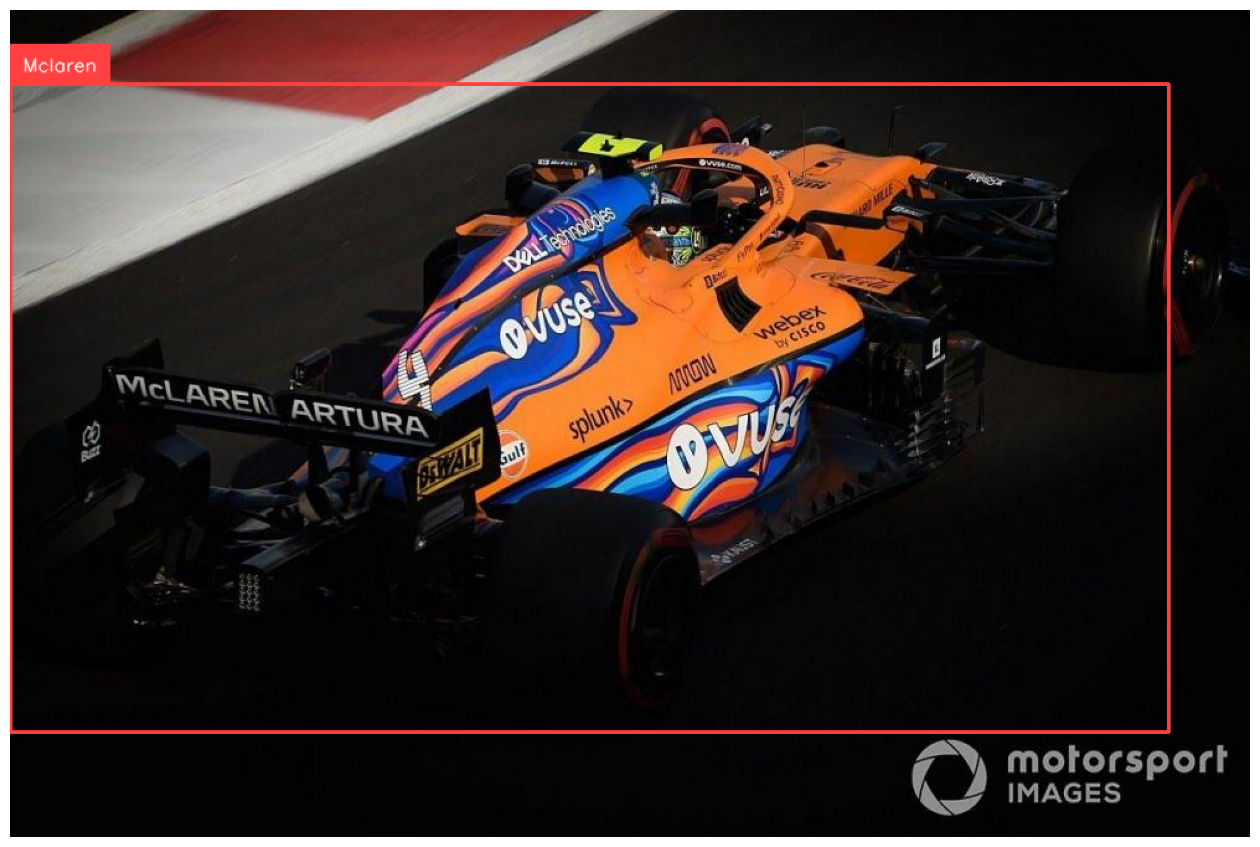

In [4]:
# annotate single image with Roboflow model
api_key_gp = getpass.getpass()
rf = Roboflow(api_key=api_key_gp)
project = rf.workspace().project("detection-f1-cars")
model = project.version(11).model
image_filepath = "./input/lando-norris-mclaren-mcl35m-1.png"

result = model.predict(image_filepath, confidence=40, overlap=30).json()

labels = [item["class"] for item in result["predictions"]]

detections = sv.Detections.from_roboflow(result)

label_annotator = sv.LabelAnnotator()
box_annotator = sv.BoxAnnotator()

image = cv2.imread(image_filepath)

annotated_image = box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(16, 16))

In [6]:
# annotate single image with Roboflow model
api_key_gp = getpass.getpass()
rf = Roboflow(api_key=api_key_gp)
project = rf.workspace().project("detection-f1-cars")
model = project.version(11).model

result = model.predict("./input/lando-norris-mclaren-mcl35m-1.png", confidence=40, overlap=30).json()

detections = sv.Detections.from_roboflow(result)

print(len(detections))
print(detections)

# filter by class
detections = detections[detections.class_id == 0]
print(detections)
print(len(detections))

loading Roboflow workspace...
loading Roboflow project...
1
Detections(xyxy=array([[  0.,  60., 934., 582.]]), mask=None, confidence=array([0.55916023]), class_id=array([1]), tracker_id=None, data={'class_name': array(['Mclaren'], dtype='<U7')})
Detections(xyxy=array([], shape=(0, 4), dtype=float64), mask=None, confidence=array([], dtype=float64), class_id=array([], dtype=int64), tracker_id=None, data={'class_name': array([], dtype='<U7')})
0


SupervisionWarnings: from_roboflow is deprecated: `Detections.from_roboflow` is deprecated and will be removed in `supervision-0.22.0`. Use `Detections.from_inference` instead.


In [62]:
import numpy as np
import supervision as sv
from roboflow import Roboflow
import tempfile

SOURCE_VIDEO_PATH = "./input/sample_video.mp4"
TARGET_VIDEO_PATH = "./input/sample_video_out.mp4"

# use https://roboflow.github.io/polygonzone/ to get the points for your line
polygon = np.array([
    # draw 50x50 box in top left corner
    [0, 0],
    [50, 0],
    [50, 50],
    [0, 50]
])

classes = {
    1: "Williams",
    37: "Alpine",
    3: "Red_Bull",
    797: "Ferrari",
    773: "Haas",
    1107: "Mercedes",
    808: "McLaren",
    2: "Alpha_Tauri",
    0: "BWT"
}

colors = sv.ColorPalette(colors=[
    sv.Color(r=0, g=130, b=250), 
    sv.Color(r=255, g=245, b=0), 
    sv.Color(r=6, g=0, b=239), 
    sv.Color(r=192, g=0, b=0), 
    sv.Color(r=120, g=120, b=120), 
    sv.Color(r=0, g=210, b=190), 
    sv.Color(r=255, g=135, b=0), 
    sv.Color(r=200, g=200, b=200), 
    sv.Color(r=255, g=0, b=255)
    ])

api_key_gp = getpass.getpass()
rf = Roboflow(api_key=api_key_gp)
project = rf.workspace().project("detection-f1-cars")
model = project.version(11).model

# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create PolygonZone instance
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(video_info.width, video_info.height))

# create box annotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2, color=colors.colors[indeks])
    
# create instance of BoxAnnotator
zone_annotator = sv.PolygonZoneAnnotator(thickness=4, text_thickness=4, text_scale=2, zone=zone, color=colors.colors[indeks])

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    # with tempfile.NamedTemporaryFile(suff?ix=".jpg") as temp:
    results = model.predict(frame).json()

    detections = sv.Detections.from_inference(results)

    # tracking detections
    detections = byte_tracker.update_with_detections(detections)

    labels = []
    indeks = 0 # default color

    for single_detection in detections:
        if type(single_detection) is tuple:
            class_chosen = single_detection[3]
            probability = int(round(single_detection[2]*100,0))
        else:
            class_chosen = single_detection.class_id[0]
            probability = int(round(single_detection.confidence*100,0))
            
        long_label = "{}, probability: {}%".format(classes[class_chosen], probability)
        indeks = list(classes.keys()).index(class_chosen)
        labels.append(long_label)

    box_annotator.color = colors.colors[indeks]
    zone_annotator.color = colors.colors[indeks]
    
    annotated_frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    annotated_frame = zone_annotator.annotate(scene=annotated_frame)

    # return frame with box and line annotated result
    return annotated_frame

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

loading Roboflow workspace...
loading Roboflow project...


SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [1]:
!pip freeze > environment.yaml